# 读取数据的类

In [1]:
from datetime import datetime
import pymongo
import pandas as pd

# get data dict, key(symbol):values(dataframe)
class mongodbCryptoData(object):
    # get data form mongodb
    def __init__(self, symbolList, dataDict, start, end=datetime.now(), rule='H'):
        self.symbolList = symbolList
        self.dataDict = dataDict
        self.rule = rule
        self.start = start
        self.end = end
        self.rule = rule

    def _readAll(self, collection):
        return pd.DataFrame(
            list(collection.find({"datetime": {'$gt': self.start, '$lt': self.end}}))
        )

    def getSymbols(self):
        for s in self.symbolList:
            self.dataDict.update({s: self._readAll(self.dataDict[s])})

    def _resampleCandle(self, df, rule):
        df = df.set_index('datetime')
        if rule=='1min':
            return df
        resampled = df.resample(rule, label='right').agg({'open':'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume':'sum'})
        return resampled

    def getSymbolsData(self):
        for s in self.symbolList:
            self.dataDict.update({s: self._resampleCandle(self.dataDict[s], self.rule)})
        
    def runDataDict(self):
        self.getSymbols()
        self.getSymbolsData()
        return self.dataDict

In [2]:
# 设置数据库信息处理数据

In [3]:
import talib as ta
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import warnings

warnings.filterwarnings('ignore')
# Data Config
client = pymongo.MongoClient('localhost', 27017)
db_names = client.list_database_names()
print(db_names)
symbolList = ['btc_usd_cq.future:okex', 'eos_usd_cq.future:okex']
dataDict = { s: client['Kline_1Min_Auto_Db_Plus'][s] for s in symbolList}
start = datetime(2019,11,20)
end = datetime(2020, 1, 20)
rule = '1min'

mongodbData = mongodbCryptoData(symbolList, dataDict, start, end, rule)
dataDict = mongodbData.runDataDict()
# print(dataDict)
btcData = dataDict['btc_usd_cq.future:okex']
eosData = dataDict['eos_usd_cq.future:okex']

coinDf = pd.concat([btcData.close, eosData.close], keys=['btcClose', 'eosClose'], axis=1)


['Kline_1Min_Auto_Db_Plus', 'VnTrader_15Min_Db_Coin', 'VnTrader_1Min_Db_Case', 'VnTrader_1Min_Db_Coin', 'VnTrader_30Min_Db_Coin', 'VnTrader_5Min_Db_Coin', 'VnTrader_60Min_Db_Coin', 'admin', 'config', 'local']


## indicator and signal

BOLLINGER BAND DIVERGENCE(from Intermarket Trading Strategies Page 123)：

$BollingerBBottom=MA−2SD$
$BollingerBTop=MA+2SD$

$SEC1BOL=(C-BollingerBBottom)/(BollingerBTop-BollingerBBottom)$

SEC1BOL=1+(C-MA+2SD)/4SD

DIVERGENCE=EMA(3)[(SEC2BOL−SEC1BOL)/SEC1BOL ∗ 100]


Exit: holdBarCount

In [78]:
class Bollinger_divergence(object):
    def __init__(self, coinDf, paraDict):
        self.paraDict = paraDict
        self.coinDf = coinDf.dropna()
        self.maPeriod = paraDict['maPeriod']
        self.divergenceThreshold = paraDict['divergenceThreshold']
        self.holdBarCount = paraDict['holdBarCount']
        self.sharpeRatio = 0
        
    def get_EMA(self,data, days):
        emas = data.copy()   
        for i in range(len(data)):
            if i == 0:
                emas[i] = data[i]
            if i > 0:
                emas[i] = ((days - 1) * emas[i - 1] + 2 * data[i]) / (days + 1)
        return emas

    
    def idIndicator(self):
        btcMa = self.coinDf['btcClose'].rolling(self.maPeriod).mean()
        eosMa = self.coinDf['eosClose'].rolling(self.maPeriod).mean()
        btcSd = self.coinDf['btcClose'].rolling(self.maPeriod).std()
        eosSd = self.coinDf['eosClose'].rolling(self.maPeriod).std()
        
        btc_BollingerBBottom = btcMa - 2*btcSd
        btc_BollingerBTop = btcMa + 2*btcSd
        eos_BollingerBBottom = eosMa - 2*eosSd
        eos_BollingerBTop = eosMa + 2*eosSd
        SEC1BOL = 1 + (self.coinDf['btcClose']-btcMa+2*btcSd)/(4*btcSd)
        SEC2BOL = 1 + (self.coinDf['eosClose']-eosMa+2*eosSd)/(4*eosSd)      
        DIVERGENCE = [(SEC2BOL-SEC1BOL)/SEC1BOL* 100]         
        EMA_DIVERGENCE = self.get_EMA(DIVERGENCE,3)
        EMA_DIVERGENCE = np.transpose(EMA_DIVERGENCE)
        self.coinDf['EMA_DIVERGENCE'] = EMA_DIVERGENCE
        print(EMA_DIVERGENCE)
        self.coinDf['EMA_DIVERGENCE'] = self.coinDf['EMA_DIVERGENCE'][:-3]
        
    def twoSymbolChart(self):
        coinArray = self.coinDf.T.values
        fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(15, 10))
        ax1.plot(coinArray[0],'r')
        ax1.grid(True)
        ax1.legend(['btc'],loc =2)
        ax2 = ax1.twinx()  #双坐标
        ax2.plot(coinArray[1])
        ax2.legend(['eos'],loc = 4)
        ax3.plot(coinArray[2])
        if not os.path.isdir('./idBtcEosChart'):
            os.mkdir('./idBtcEosChart')
            plt.savefig('./idBtcEosChart/Ma%s_Cor%s.jpg'%(self.maPeriod, self.divergenceThreshold))
        else:
            plt.savefig('./idBtcEosChart/Ma%s_Cor%s.jpg'%(self.maPeriod, self.divergenceThreshold))
        
    def calSignals(self):
        coinArray = self.coinDf.T.values
        eos_coinArray = coinArray[1]
        coinNowL = coinArray[2][1:]
        coinNowR = coinArray[2][:-1]
        coinShift = coinArray[2][:-1]
        coinForward = coinArray[2][1:]
  
        Short = np.where((coinNowL<-self.divergenceThreshold) & (coinNowL<coinShift)& (coinForward>coinNowR) , 1, 0)
        Buy = np.where((coinNowL>self.divergenceThreshold)  & (coinForward<coinNowR) , 1, 0)
        #& (coinForward>coinNowR)
        #& (coinForward<coinNowR)
        buyPoint = np.where(Buy>0)
        shortPoint = np.where(Short>0)
        print(buyPoint)
        buyPrice = coinArray[1][1:][buyPoint]
        sellPrice = coinArray[1][1:][buyPoint[0]+self.holdBarCount]
        shortPrice = coinArray[1][1:][shortPoint]
        coverPrice = coinArray[1][1:][shortPoint[0]+self.holdBarCount]

        zipBuy = zip(buyPoint[0] , (sellPrice - buyPrice))
        zipShort = zip(shortPoint[0], (shortPrice - coverPrice ))
        return zipBuy, zipShort
    
    def perfPlotSave(self, zipBuy, zipShort):
        
        coinArray = self.coinDf.T.values
        perfResult = sorted(itertools.chain(zipBuy, zipShort), key= lambda item: item[0])
        
        perfIndex = np.array(perfResult, dtype=int).T[0, :]
        perOrderValue = np.array(perfResult).T[1, :]

        priceEos = coinArray[1][1:][perfIndex]
        perfReturn = perOrderValue/priceEos
        sharpeRatio = perfReturn.mean()/perfReturn.std()*np.sqrt(240)
        perfSum = perOrderValue.cumsum()
        fig, ax4 = plt.subplots(1, 1, figsize=(15, 7))
        ax4.plot(perfSum)
        if not os.path.isdir('./idBtcEosPerf'):
            os.mkdir('./idBtcEosPerf')
            plt.savefig('./idBtcEosPerf/Ma%s_Cor%s_TH%s_HBC%s.jpg'\
                %(self.maPeriod, self.divergenceThreshold, self.holdBarCount))
        else:
            plt.savefig('./idBtcEosPerf/Ma%s_Cor%s_TH%s_HBC%s.jpg'\
                %(self.maPeriod, self.divergenceThreshold, self.holdBarCount))
        self.paraDict.update({'sharpeRatio': round(sharpeRatio,3),\
                              'orderTime':len(perfResult)})
        
    def runSignalTest(self):
        self.idIndicator()
        self.twoSymbolChart()
        zipBuy, zipShort = self.calSignals()
        resultDict = self.perfPlotSave(zipBuy, zipShort)
        return self.paraDict
    

[[         nan]
 [         nan]
 [         nan]
 ...
 [-33.990602  ]
 [-18.22874789]
 [  0.05279244]]
(array([ 3095, 13280, 13281, 20035, 20563, 22236, 22241, 23298, 23423,
       25368, 25369, 25793, 25794, 27591, 28302, 29054, 32063, 34145,
       46299, 46548, 46549, 53227, 54392, 55191, 55192, 57982, 57983,
       59184, 63772, 78004, 78088, 78089, 78400, 78542, 86529, 87174],
      dtype=int64),)


TypeError: not enough arguments for format string

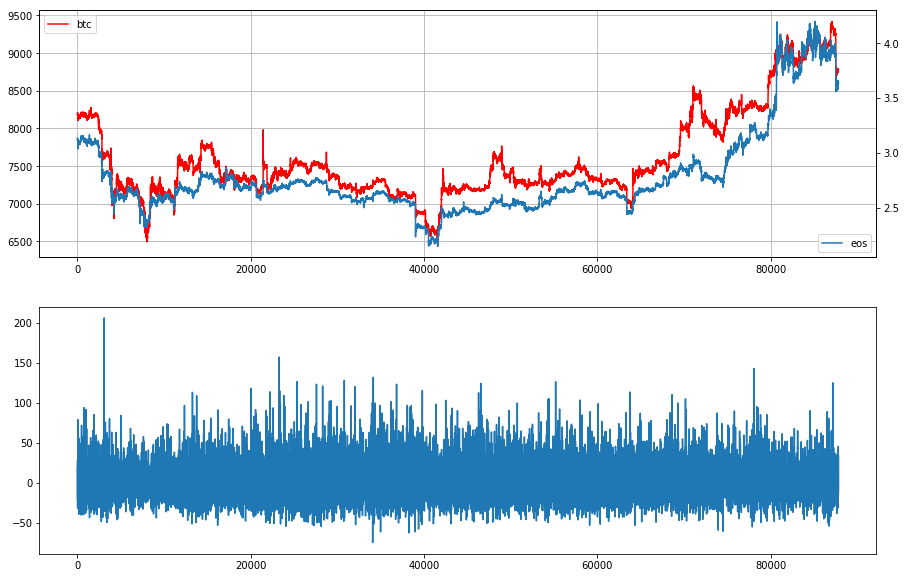

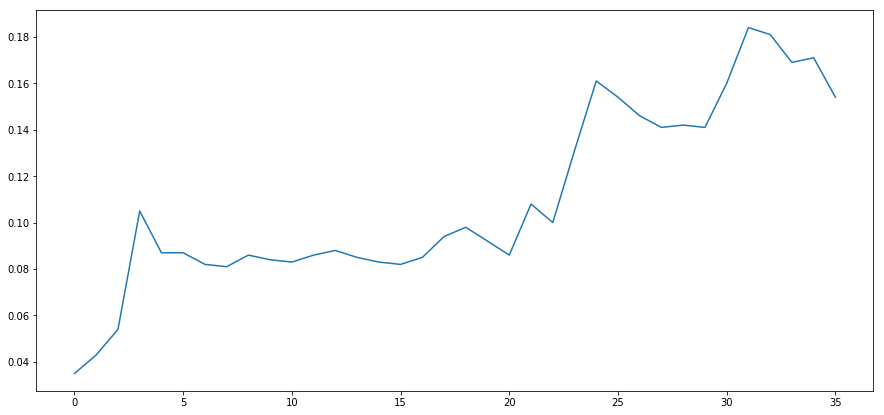

In [89]:
paraDict = {'maPeriod':15,  'divergenceThreshold':70, 'holdBarCount':30}
coinSig = Bollinger_divergence(coinDf, paraDict)
coinSig.runSignalTest()

## 参数优化

In [85]:
import numpy as np
from itertools import product

paramDict = {'maPeriod': range(140,161,20),  \
            'divergenceThreshold':np.arange(2, 2.5, 0.4),'holdBarCount': range(30, 61, 30)}

nameList = paramDict.keys()
paramList = paramDict.values()
# 使用迭代工具生产参数对组合
productList = list(product(*paramList))

# 把参数对组合打包到一个个字典组成的列表中
settingList = []
for p in productList:
    d = dict(zip(nameList, p))
    settingList.append(d)

print(settingList[-5:])

[{'maPeriod': 140, 'divergenceThreshold': 2.4, 'holdBarCount': 60}, {'maPeriod': 160, 'divergenceThreshold': 2.0, 'holdBarCount': 30}, {'maPeriod': 160, 'divergenceThreshold': 2.0, 'holdBarCount': 60}, {'maPeriod': 160, 'divergenceThreshold': 2.4, 'holdBarCount': 30}, {'maPeriod': 160, 'divergenceThreshold': 2.4, 'holdBarCount': 60}]


[[        nan]
 [        nan]
 [        nan]
 ...
 [-5.78282505]
 [-3.04468419]
 [ 0.630997  ]]
(array([  139,   211,   213, ..., 87820, 87821, 87822], dtype=int64),)


IndexError: index 87831 is out of bounds for axis 0 with size 87826

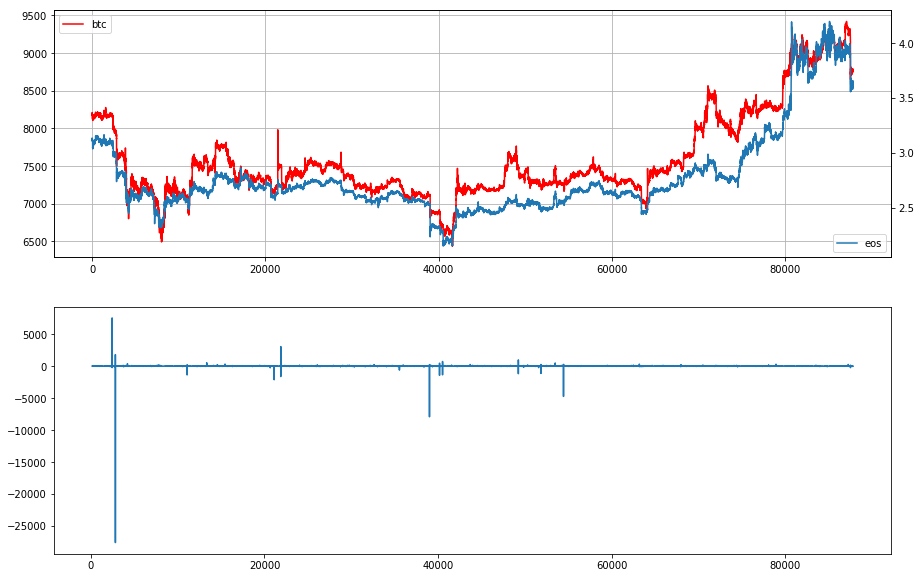

In [86]:
paramResultList = []
for newParam in settingList:
    coinSig = Bollinger_divergence(coinDf, newParam)
    paramResult = coinSig.runSignalTest()
    paramResultList.append(paramResult)
    print('Done:', newParam)

In [33]:
result = pd.DataFrame(paramResultList).sort_values('sharpeRatio', ascending=False)

KeyError: 'sharpeRatio'

In [26]:
resultOrder = result[(result.orderTime>20) & (result.sharpeRatio>0)]

NameError: name 'result' is not defined

In [ ]:
resultOrder

In [ ]:
resultOrder.to_excel('date%s%s%s%s.xlsx'%(str(start.year),str(start.month),str(end.year),str(end.month)))